Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000 

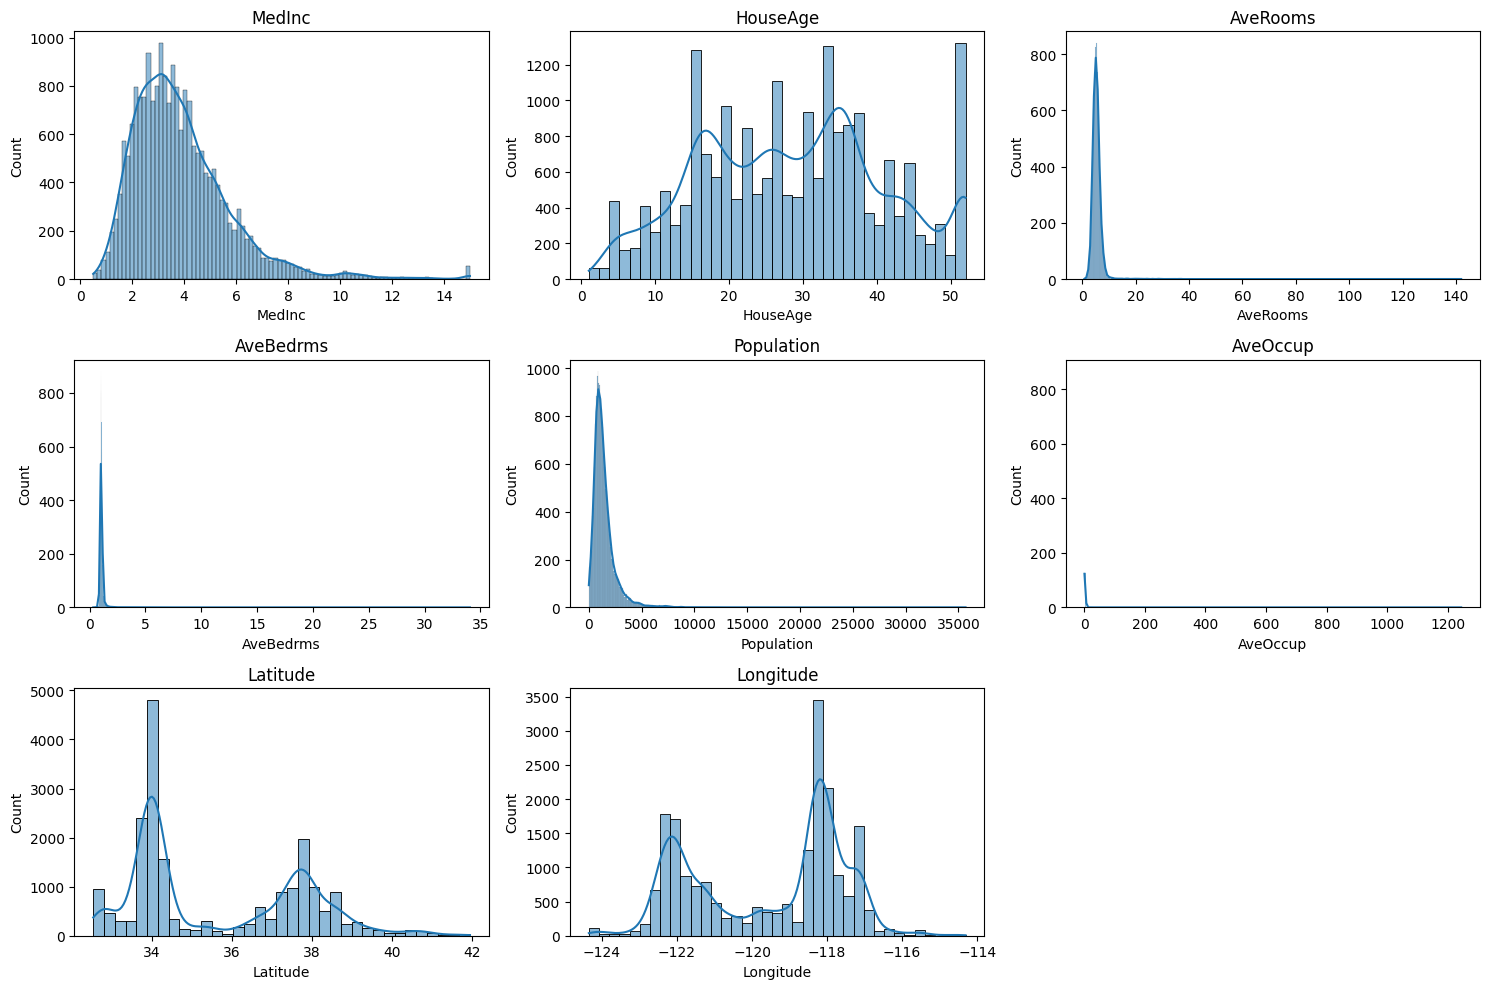

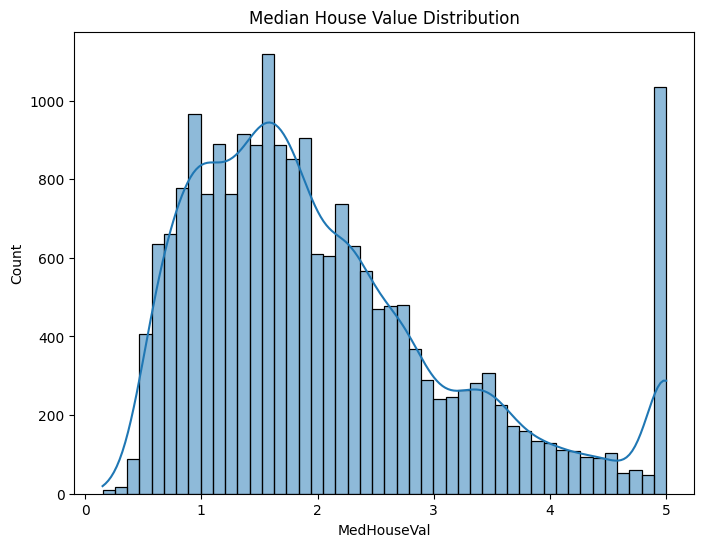

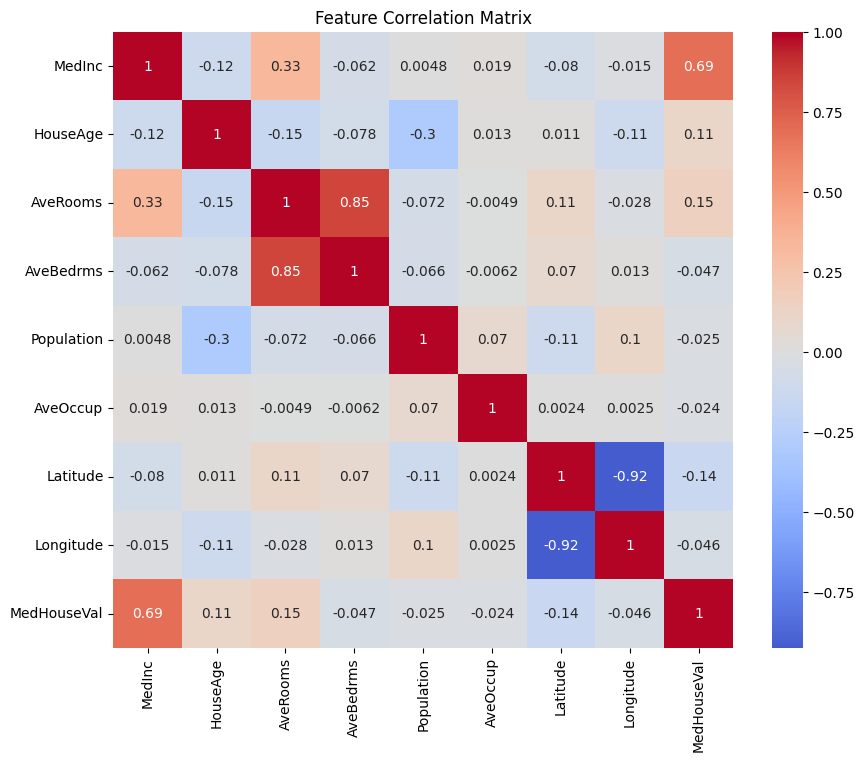


Training Enhanced MLP...


ValueError: Input contains NaN.

In [2]:
import numpy as np
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

class MLP:
    """
    A flexible Multilayer Perceptron implementation that can handle both classification and regression.
    """

    def __init__(self, layer_sizes, activation='relu', output_activation=None,
                 learning_rate=0.01, epochs=1000, batch_size=32,
                 validation_split=0.2, early_stopping=True, patience=10):
        """
        Initialize the MLP.

        Parameters:
        - layer_sizes: List of integers specifying the number of neurons in each layer
                       (including input and output layers)
        - activation: Activation function for hidden layers ('relu', 'sigmoid', 'tanh')
        - output_activation: Activation function for output layer
        - learning_rate: Learning rate for gradient descent
        - epochs: Maximum number of training epochs
        - batch_size: Size of mini-batches for training
        - validation_split: Fraction of data to use for validation
        - early_stopping: Whether to stop training if validation loss doesn't improve
        - patience: Number of epochs to wait before early stopping
        """
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.early_stopping = early_stopping
        self.patience = patience

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes)-1):
            # He initialization for ReLU, Xavier for others
            if activation == 'relu':
                scale = np.sqrt(2/layer_sizes[i])
            else:
                scale = np.sqrt(1/layer_sizes[i])
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * scale)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

        # History tracking
        self.train_loss_history = []
        self.val_loss_history = []

    def _activation_fn(self, x, activation):
        """Apply activation function"""
        if activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif activation == 'tanh':
            return np.tanh(x)
        elif activation == 'relu':
            return np.maximum(0, x)
        elif activation == 'softmax':
            exps = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)
        elif activation is None:
            return x  # Linear activation
        else:
            raise ValueError(f"Unknown activation function: {activation}")

    def _activation_derivative(self, x, activation):
        """Compute derivative of activation function"""
        if activation == 'sigmoid':
            s = self._activation_fn(x, 'sigmoid')
            return s * (1 - s)
        elif activation == 'tanh':
            return 1 - np.tanh(x)**2
        elif activation == 'relu':
            return (x > 0).astype(float)
        elif activation == 'softmax':
            # Note: This is simplified for the output layer
            s = self._activation_fn(x, 'softmax')
            return s * (1 - s)
        elif activation is None:
            return np.ones_like(x)
        else:
            raise ValueError(f"Unknown activation function: {activation}")

    def _compute_loss(self, y_true, y_pred, problem_type):
        """Compute loss based on problem type"""
        if problem_type == 'classification':
            # Cross-entropy loss
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            return -np.mean(y_true * np.log(y_pred))
        elif problem_type == 'regression':
            # Mean squared error
            return mean_squared_error(y_true, y_pred)
        else:
            raise ValueError("Problem type must be 'classification' or 'regression'")

    def _forward_pass(self, X):
        """Perform forward pass through the network"""
        activations = [X]
        layer_input = X

        for i in range(len(self.weights)-1):
            z = np.dot(layer_input, self.weights[i]) + self.biases[i]
            a = self._activation_fn(z, self.activation)
            activations.append(a)
            layer_input = a

        # Output layer
        z = np.dot(layer_input, self.weights[-1]) + self.biases[-1]
        a = self._activation_fn(z, self.output_activation)
        activations.append(a)

        return activations

    def _backward_pass(self, activations, y_true, problem_type):
        """Perform backward pass and compute gradients"""
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        # Number of samples
        m = y_true.shape[0]

        # Output error
        if problem_type == 'classification':
            if self.output_activation == 'softmax':
                delta = (activations[-1] - y_true) / m
            else:
                delta = (activations[-1] - y_true) * self._activation_derivative(
                    np.dot(activations[-2], self.weights[-1]) + self.biases[-1],
                    self.output_activation)
        else:  # regression
            delta = (activations[-1] - y_true) * self._activation_derivative(
                np.dot(activations[-2], self.weights[-1]) + self.biases[-1],
                self.output_activation)

        gradients_w[-1] = np.dot(activations[-2].T, delta)
        gradients_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # Backpropagate through hidden layers
        for l in range(len(self.weights)-2, -1, -1):
            delta = np.dot(delta, self.weights[l+1].T) * self._activation_derivative(
                np.dot(activations[l], self.weights[l]) + self.biases[l],
                self.activation)
            gradients_w[l] = np.dot(activations[l].T, delta)
            gradients_b[l] = np.sum(delta, axis=0, keepdims=True)

        return gradients_w, gradients_b

    def fit(self, X, y, problem_type='classification', verbose=1):
        """
        Train the MLP.

        Parameters:
        - X: Input features
        - y: Target values
        - problem_type: 'classification' or 'regression'
        - verbose: 0 for silent, 1 for progress updates
        """
        # Preprocess data based on problem type
        if problem_type == 'classification':
            # Convert y to one-hot encoding if needed
            if len(y.shape) == 1 or y.shape[1] == 1:
                self.classes_ = np.unique(y)
                y_onehot = np.zeros((y.shape[0], len(self.classes_)))
                y_onehot[np.arange(y.shape[0]), y.astype(int)] = 1
                y = y_onehot
        elif problem_type == 'regression':
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
        else:
            raise ValueError("Problem type must be 'classification' or 'regression'")

        # Split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=self.validation_split, random_state=42)

        # Standardize features
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val = self.scaler.transform(X_val)

        # Training variables
        best_val_loss = float('inf')
        no_improvement_count = 0

        # Training loop
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)

            for start in range(0, X_train.shape[0], self.batch_size):
                end = start + self.batch_size
                if end > X_train.shape[0]:
                    end = X_train.shape[0]

                batch_indices = indices[start:end]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]

                # Forward pass
                activations = self._forward_pass(X_batch)

                # Backward pass
                gradients_w, gradients_b = self._backward_pass(
                    activations, y_batch, problem_type)

                # Update weights and biases
                for i in range(len(self.weights)):
                    self.weights[i] -= self.learning_rate * gradients_w[i]
                    self.biases[i] -= self.learning_rate * gradients_b[i]

            # Compute losses
            train_pred = self._forward_pass(X_train)[-1]
            train_loss = self._compute_loss(y_train, train_pred, problem_type)
            self.train_loss_history.append(train_loss)

            val_pred = self._forward_pass(X_val)[-1]
            val_loss = self._compute_loss(y_val, val_pred, problem_type)
            self.val_loss_history.append(val_loss)

            # Early stopping check
            if self.early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_count = 0
                    # Save best weights
                    self.best_weights = [w.copy() for w in self.weights]
                    self.best_biases = [b.copy() for b in self.biases]
                else:
                    no_improvement_count += 1

                if no_improvement_count >= self.patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    # Restore best weights
                    self.weights = [w.copy() for w in self.best_weights]
                    self.biases = [b.copy() for b in self.best_biases]
                    break

            # Progress update
            if verbose and (epoch % (self.epochs//10) == 0 or epoch == self.epochs-1):
                print(f"Epoch {epoch+1}/{self.epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

        return self

    def predict(self, X):
        """Make predictions"""
        X = self.scaler.transform(X)
        output = self._forward_pass(X)[-1]

        if hasattr(self, 'classes_'):
            # Classification problem
            if self.output_activation == 'softmax':
                return np.argmax(output, axis=1)
            else:
                return (output > 0.5).astype(int)
        else:
            # Regression problem
            return output

    def plot_loss_history(self):
        """Plot training and validation loss history"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss History')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage

# Create synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=15, random_state=42)

# Initialize and train MLP
mlp = MLP(layer_sizes=[20, 64, 32, 2],  # Input: 20, Hidden: 64 and 32, Output: 2
          activation='relu',
          output_activation='softmax',
          learning_rate=0.01,
          epochs=200,
          batch_size=32)

mlp.fit(X, y, problem_type='classification', verbose=1)

# Plot loss history
mlp.plot_loss_history()

# Make predictions
y_pred = mlp.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")

# Regression example
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, n_targets=1, noise=0.1, random_state=42)

mlp_reg = MLP(layer_sizes=[20, 64, 32, 1],  # Input: 20, Hidden: 64 and 32, Output: 1
             activation='relu',
             output_activation=None,  # Linear activation for regression
             learning_rate=0.001,
             epochs=200,
             batch_size=32)

mlp_reg.fit(X_reg, y_reg, problem_type='regression', verbose=1)

# Plot loss history
mlp_reg.plot_loss_history()

# Make predictions
y_pred_reg = mlp_reg.predict(X_reg)
print(f"MSE: {mean_squared_error(y_reg, y_pred_reg):.4f}")